# Analysis of subset of data used to create mini-scene dataset to train behavior recognition model

See the KABR mini-scene dataset in HF here: https://huggingface.co/datasets/imageomics/KABR

Refer to our previous papers for details of the mini-scene dataset:
- [KABR: In-Situ Dataset for Kenyan Animal Behavior
Recognition from Drone Videos](https://openaccess.thecvf.com/content/WACV2024W/CV4Smalls/papers/Kholiavchenko_KABR_In-Situ_Dataset_for_Kenyan_Animal_Behavior_Recognition_From_Drone_WACVW_2024_paper.pdf)
- [Deep dive into KABR: a dataset for understanding ungulate behavior from in-situ drone video](https://doi.org/10.1007/s11042-024-20512-4)

In [23]:
# import libraries
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

In [24]:
# import metadata on drone sessions used to create mini-scenes
data = pd.read_csv('data/miniscene_sessions_summary.csv')

In [25]:
# get number of sessions
num_sessions = data['Session '].nunique()
print(f'Number of sessions: {num_sessions}')

Number of sessions: 16


In [26]:
# calculate duration of each session and get the min, max, and avg
data['Duration'] = pd.to_timedelta(data['End Time']) - pd.to_timedelta(data['Start Time'])
min_duration = data['Duration'].min()
max_duration = data['Duration'].max()
avg_duration = data['Duration'].mean()

print(f'Minimum session duration: {min_duration}')
print(f'Maximum session duration: {max_duration}')
print(f'Average session duration: {avg_duration}')

Minimum session duration: 0 days 00:05:00
Maximum session duration: 0 days 00:52:14
Average session duration: 0 days 00:24:16.375000


In [27]:
# get avg, min, and max herd size
avg_herd_size = data['Herd Size'].mean()
min_herd_size = data['Herd Size'].min()
max_herd_size = data['Herd Size'].max()
print(f'Average herd size: {avg_herd_size}')
print(f'Minimum herd size: {min_herd_size}')
print(f'Maximum herd size: {max_herd_size}')

Average herd size: 6.0625
Minimum herd size: 2.0
Maximum herd size: 16.0


# Analyze consolidated metadata file
This file contains behavior annotations, bounding boxes, and telemetry (altitude, GPS, etc.) for each frame in the video. Each row contains the video and mini-scene id.

See previously released 'consolidated_metadata.csv' file in the [Hugging Face dataset](https://huggingface.co/datasets/imageomics/kabr-datapalooza-2023-subset/tree/main/data/consolidated_metadata.csv) for data.

In [28]:
# import data
df = pd.read_csv('data/consolidated_metadata.csv')

In [29]:
# find the number of mini-scenes
# count the number of unique id and video combinations

df['mini-scene-id'] = df['video'] + '_' + df['id'].astype(str)
# count unique mini-scene ids
mini_scene_count = df['mini-scene-id'].nunique()
print(f'The number of unique mini-scenes in the dataset is: {mini_scene_count}')

The number of unique mini-scenes in the dataset is: 807


In [30]:
# create video id and date columns from video
df['video_id'] = df['video'].str.split('-').str[1]

# extract date from video name
df['date'] = df['video'].str.split('-').str[0]
# keep only the first 8 characters of the date
df['date'] = df['date'].str[:8]

In [31]:
# calculate number of mini-scenes per date
# Extract day from the video name
df['day'] = df["date"].str.extract(r"(\d{2})") 

# Calculate the number of mini-scenes per date
mini_scenes_per_day = df.groupby('day')['mini-scene-id'].nunique()

print("Number of mini-scenes per date:")
print(mini_scenes_per_day)

# calculate number of mini-scenes per video
mini_scenes_per_video = df.groupby('video')['mini-scene-id'].nunique()
# print("Number of mini-scenes per video:")
# print(mini_scenes_per_video)

Number of mini-scenes per date:
day
11     62
12    146
13    438
16    112
17     49
Name: mini-scene-id, dtype: int64


### Create lookup of video to species from the summary file

In [32]:
# import dataset of mini-scenes with species labels
species_df = pd.read_csv('data/miniscene_sessions_summary.csv')


In [33]:
# from data file, create summary of data, video, and species
data_species = species_df[['Date ', 'Species','Video File Names']].drop_duplicates()

# create lookup joining date with video file names, e.g. '12_01_23-DJI_0994'
# new row for each data, video file name, and species
data_species['video_id'] = data_species['Video File Names'].str.split(',')
# explode the Video File Names column to have one row per video file name
data_species = data_species.explode('video_id')

data_species['day'] = data_species['Date '].str.extract(r'(\d{2})')  # Extract day from the date

data_species = data_species[['day', 'video_id', 'Species']]

# strip whitespace from video_id
data_species['video_id'] = data_species['video_id'].str.strip()

data_species['day_video'] = data_species['day'] + '-' + data_species['video_id']

data_species.head()

,day,video_id,Species,day_video
0,11,DJI_0977,Grevy's,11-DJI_0977
0,11,DJI_0978,Grevy's,11-DJI_0978
0,11,DJI_0979,Grevy's,11-DJI_0979
0,11,DJI_0980,Grevy's,11-DJI_0980
1,12,DJI_0987,Plains,12-DJI_0987


### Calculate the number of mini scenes by species using lookup table

In [34]:
df_counts = mini_scenes_per_video.rename("mini_scene_count").reset_index()
df_counts.columns = ['video', 'mini_scene_count']

# Extract date from 'video' column in df_counts
df_counts['day'] =df_counts['video'].str.extract(r'(\d{2})_')  # just day part
df_counts['video_id'] = df_counts['video'].str.extract(r'(DJI_\d{4})')
# strip whitespace from video_id
df_counts['video_id'] = df_counts['video_id'].str.strip()
df_counts['day_video'] = df_counts['day'] + '-' + df_counts['video_id']

df_counts = df_counts[['day_video', 'mini_scene_count']]

df_merged = df_counts.merge(data_species, on=['day_video'], how='left')

mini_scenes_per_species = df_merged.groupby('Species')['mini_scene_count'].sum().reset_index()

print(mini_scenes_per_species)

sum(mini_scenes_per_species['mini_scene_count'])  # Total mini-scenes across all species



     Species  mini_scene_count
0   Giraffes                40
1  Giraffes                 22
2   Grevy's                174
3      Mixed               198
4     Plains               307
5    Plains                 66


807

### Get number of unique behaviors captured in the dataset

In [35]:
df['behaviour'].value_counts()

behaviour
Graze              382268
Walk               320872
Head Up            252316
Out of Focus        62549
Walking             44893
Out of Frame        18813
Occluded            18701
Running             18674
Browsing            14721
Trotting            13479
Auto-Groom           5866
Defecating           2172
Sniff                 580
Mutual Grooming       413
Urinating             335
Fighting               29
Name: count, dtype: int64

In [36]:
# drop rows with behavior out of focus, out of frame, or occluded
df = df[df['behaviour'] != 'Out of Focus']
df = df[df['behaviour'] != 'Out of Frame']
df = df[df['behaviour'] != 'Occluded']

df['behaviour'].value_counts()

behaviour
Graze              382268
Walk               320872
Head Up            252316
Walking             44893
Running             18674
Browsing            14721
Trotting            13479
Auto-Groom           5866
Defecating           2172
Sniff                 580
Mutual Grooming       413
Urinating             335
Fighting               29
Name: count, dtype: int64

In [37]:
# rename for clarity
df['behaviour'] = df['behaviour'].replace('Walk', 'Walking')
df['behaviour'] = df['behaviour'].replace('Walking', 'Walk')
df['behaviour'] = df['behaviour'].replace('Running', 'Run')
df['behaviour'] = df['behaviour'].replace('Trotting', 'Trot')
df['behaviour'] = df['behaviour'].replace('Defecating', 'Defecate')
df['behaviour'] = df['behaviour'].replace('Urinating', 'Urinate')
df['behaviour'] = df['behaviour'].replace('Mutual Grooming', 'Mutual-Groom')
df['behaviour'] = df['behaviour'].replace('Fighting', 'Fight')
df['behaviour'] = df['behaviour'].replace('Browsing', 'Browse')

In [38]:
df['behaviour'].unique()

array(['Walk', 'Head Up', 'Graze', 'Auto-Groom', 'Defecate', 'Trot',
       'Run', 'Browse', 'Sniff', 'Mutual-Groom', 'Urinate', 'Fight'],
      dtype=object)

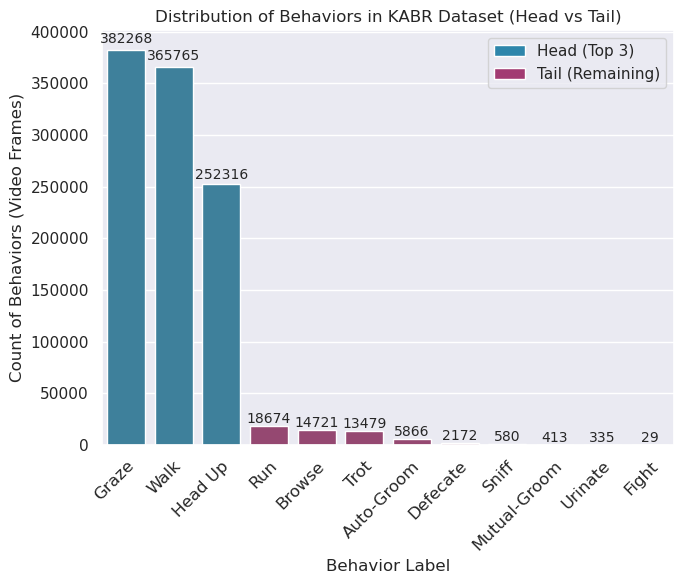

In [44]:
# plot distribution of behaviors
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="darkgrid")

# Set figure size BEFORE creating the plot
plt.figure(figsize=(7, 6))

# Get the order of behaviors by count
behavior_order = df['behaviour'].value_counts().index

# Create color palette: different colors for head (first 3) vs tail (remainder)
n_behaviors = len(behavior_order)
colors = ['#2E86AB'] * 3 + ['#A23B72'] * (n_behaviors - 3)  # Blue for head, purple for tail
# Alternative color scheme:
# colors = ['steelblue'] * 3 + ['lightcoral'] * (n_behaviors - 3)

# Create the plot with custom colors
ax = sns.countplot(x="behaviour", data=df, order=behavior_order, palette=colors)

for i, bar in enumerate(ax.patches):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
            f'{int(height)}', ha='center', va='bottom', fontsize=10)

# add labels
plt.xlabel('Behavior Label')
plt.ylabel('Count of Behaviors (Video Frames)')

# add title
plt.title('Distribution of Behaviors in KABR Dataset (Head vs Tail)')

# rotate x-axis labels
plt.xticks(rotation=45)

# Add legend to distinguish head vs tail
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='#2E86AB', label='Head (Top 3)'),
                   Patch(facecolor='#A23B72', label='Tail (Remaining)')]
ax.legend(handles=legend_elements, loc='upper right')

plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor", fontsize=12)

plt.tight_layout()  # Helps with label spacing
plt.show()

In [97]:
# find the number of mini-scenes
# count the number of unique id and video combinations

# create 
df['mini-scene-id'] = df['video'] + '_' + df['id'].astype(str)
# count unique mini-scene ids
mini_scene_count = df['mini-scene-id'].nunique()
print(f'The number of unique mini-scenes in the dataset is: {mini_scene_count}')

# print the unique videos
unique_videos = df['video'].unique()
print(f'The number of unique videos in the dataset is: {len(unique_videos)}')
print(f'Unique videos: {unique_videos}')

The number of unique mini-scenes in the dataset is: 801
The number of unique videos in the dataset is: 58
Unique videos: ['12_01_23-DJI_0994' '16_01_23_session_2-DJI_0002' '13_01_23-DJI_0037'
 '11_01_23-DJI_0979' '13_01_23-DJI_0020' '13_01_23-DJI_0019'
 '17_01_2023_session_2-DJI_0013' '13_01_23-DJI_0039' '12_01_23-DJI_0001'
 '12_01_23-DJI_0006' '13_01_23-DJI_0041' '13_01_23-DJI_0024'
 '13_01_23-DJI_0015' '13_01_23-DJI_0031' '12_01_23-DJI_0003'
 '12_01_23-DJI_0008' '16_01_23_session_2-DJI_0003' '13_01_23-DJI_0032'
 '13_01_23-DJI_0013' '16_01_23_session_1-DJI_0001' '13_01_23-DJI_0009'
 '12_01_23-DJI_0997' '12_01_23-DJI_0989' '17_01_2023_session_2-DJI_0008'
 '11_01_23-DJI_0978' '13_01_23-DJI_0021' '13_01_23-DJI_0036'
 '17_01_2023_session_2-DJI_0010' '17_01_2023_session_1-DJI_0006'
 '16_01_23_session_1-DJI_0004' '13_01_23-DJI_0022' '13_01_23-DJI_0016'
 '12_01_23-DJI_0998' '16_01_23_session_1-DJI_0003' '12_01_23-DJI_0002'
 '13_01_23-DJI_0035' '13_01_23-DJI_0033' '17_01_2023_session_2-DJI_00

# Plot performance of X3D model

In [98]:
import numpy as np

labels = [
    "Graze", "Walk", "Head Up", "Run", 
    "Browse", "Trot", "Auto-Groom", "Out of Sight"
]

cm = np.array([
    [0.87, 0.02, 0.07, 0.00, 0.00, 0.00, 0.01, 0.02],  # Graze
    [0.04, 0.87, 0.06, 0.02, 0.00, 0.01, 0.00, 0.01],  # Walk
    [0.02, 0.01, 0.94, 0.00, 0.00, 0.02, 0.00, 0.00],  # Head Up
    [0.00, 0.19, 0.00, 0.71, 0.10, 0.00, 0.00, 0.00],  # Trot
    [0.00, 0.13, 0.00, 0.10, 0.77, 0.00, 0.00, 0.00],  # Run
    [0.48, 0.08, 0.04, 0.00, 0.00, 0.00, 0.40, 0.00],  # Browse
    [0.50, 0.00, 0.25, 0.00, 0.00, 0.00, 0.25, 0.00],  # Auto-Groom
    [0.66, 0.05, 0.11, 0.00, 0.00, 0.00, 0.00, 0.18],  # Out of Sight
])

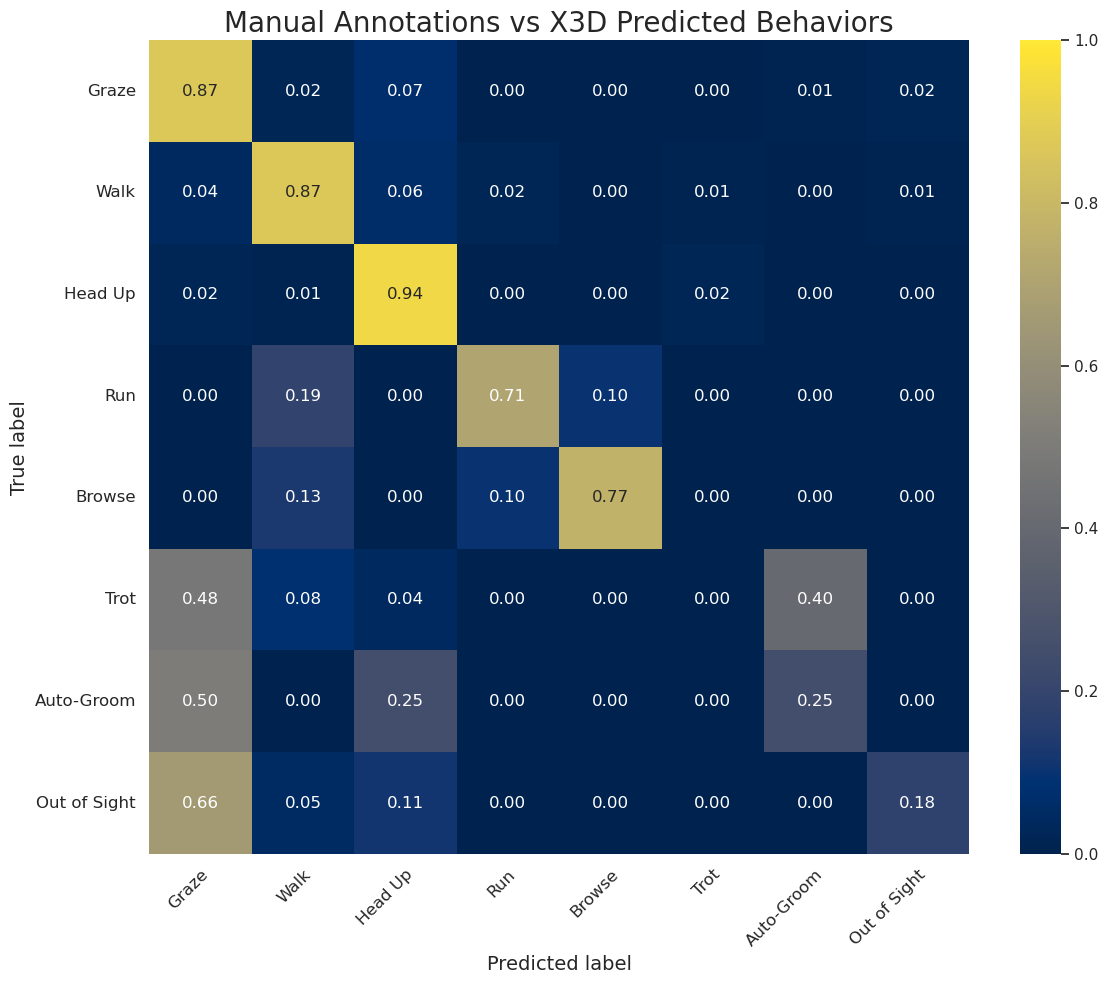

In [99]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(cm,
            annot=True, fmt=".2f",
            xticklabels=labels,
            yticklabels=labels,
            cmap='cividis', vmin=0, vmax=1)
ax.set_xlabel("Predicted label", fontsize=14)
ax.set_ylabel("True label", fontsize=14)
ax.set_title("Manual Annotations vs X3D Predicted Behaviors", fontsize=20)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor", fontsize=12)
plt.setp(ax.get_yticklabels(), rotation=0, ha="right", fontsize=12)
plt.tight_layout()
plt.show()

fig.savefig('manualvsX3D.pdf', dpi=300, bbox_inches='tight')

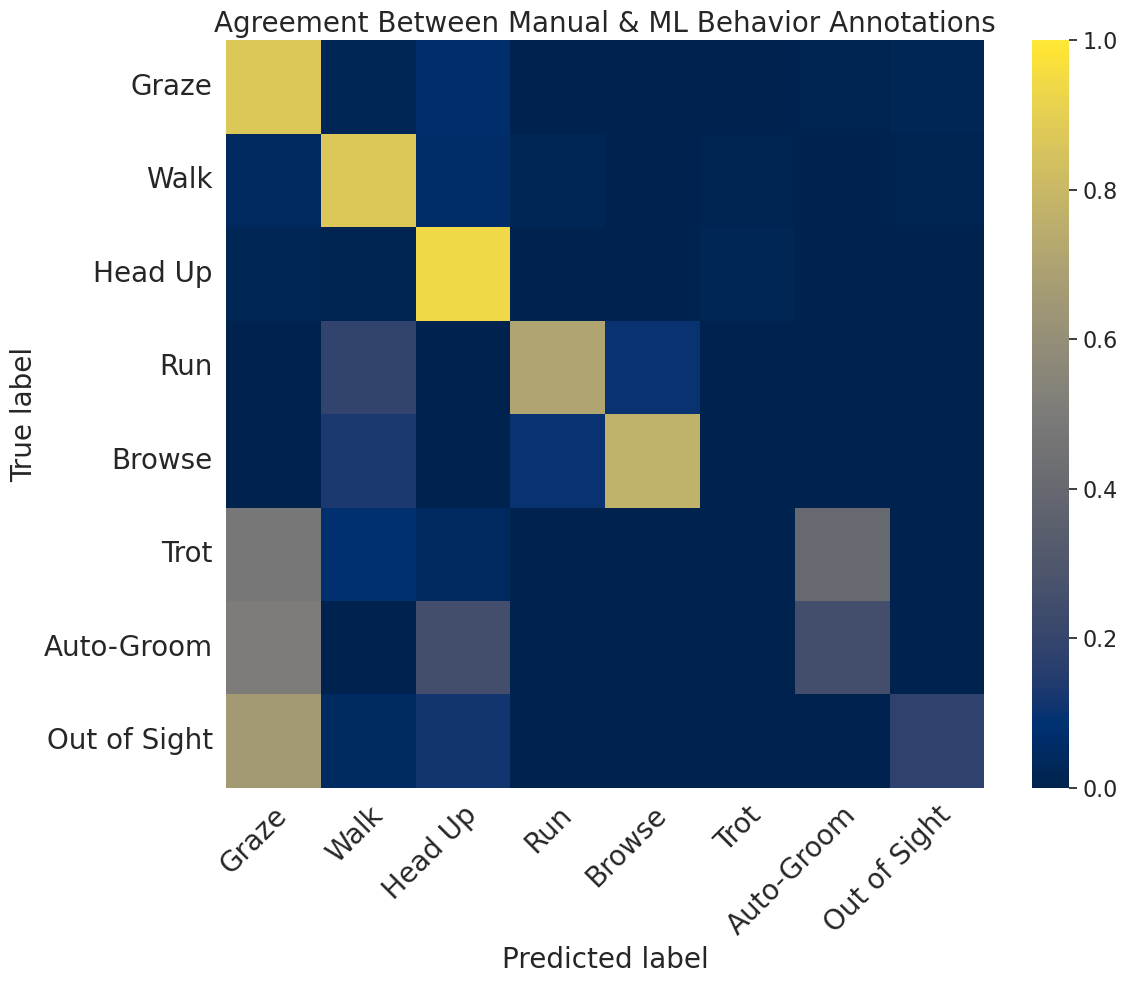

In [102]:
fig, ax = plt.subplots(figsize=(12, 10))
heatmap = sns.heatmap(cm,
            annot=False, fmt=".2f",
            xticklabels=labels,
            yticklabels=labels,
            cmap='cividis', vmin=0, vmax=1)

# Set font size for the color bar
cbar = heatmap.collections[0].colorbar
cbar.ax.tick_params(labelsize=16)

ax.set_xlabel("Predicted label", fontsize=20)
ax.set_ylabel("True label", fontsize=20)
ax.set_title("Agreement Between Manual & ML Behavior Annotations", fontsize=20)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor", fontsize=20)
plt.setp(ax.get_yticklabels(), rotation=0, ha="right", fontsize=20)
plt.tight_layout()
plt.show()

fig.savefig('manualvsX3D.pdf', dpi=300, bbox_inches='tight')